## **1 - Import des librairies**

In [ ]:
# Création de répertoires pour stocker le Git, les librairies et checkpoints
!mkdir nebulaTemp -p
!mkdir packages -p

# Copie des sources des librairies projet depuis le Github
#!git clone https://github.com/DataScientest/nebula/ ./nebulaTemp --dissociate
!git clone --single-branch --branch ludovic https://github.com/DataScientest/nebula/ ./nebulaTemp --dissociate

# Répartition des différentes ressources dans les répertoires
!cp ./nebulaTemp/packages/* ./packages

# Suppression de la copie du repository source
!rm nebulaTemp -r

Cloning into './nebulaTemp'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 123 (delta 27), reused 30 (delta 23), pack-reused 73
Receiving objects: 100% (123/123), 19.18 MiB | 32.21 MiB/s, done.
Resolving deltas: 100% (52/52), done.


Initialisation de la variable d'environnement SM_FRAMEWORK, necessaire a l'import du package segmentation_models.

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


Import des librairies

In [ ]:

import os, glob
from shutil import copyfile
import zipfile
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc, f1_score
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import Callback
from keras.layers import Dense, Flatten, LeakyReLU, Concatenate

from keras.models import Model, load_model
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion, RandomGamma 
import matplotlib.pyplot as plt
from IPython.display import Image
from numpy.random import seed
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input, Conv2DTranspose, concatenate
from keras import callbacks
from numpy import argmax
import packages
from keras.preprocessing.image import ImageDataGenerator

from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from PIL import Image
from matplotlib import patches

seed(10)
%matplotlib inline

In [ ]:
#copyfile('/content/drive/MyDrive/Colab Notebooks/projetNuages/phase3/checkpoint', './checkpoint') 
#copyfile('/content/drive/MyDrive/Colab Notebooks/projetNuages/phase3/resnet18.data-00000-of-00001', './resnet18.data-00000-of-00001') 
#copyfile('/content/drive/MyDrive/Colab Notebooks/projetNuages/phase3/resnet18.index', './resnet18.index') 

'./resnet18.index'

Installation et import du package segmentation_models

In [ ]:
pip install segmentation_models

     |████████████████████████████████| 51kB 4.3MB/s 


In [ ]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


## **2 - Import des donnees**

Copie puis decompression du zip du dataset (environ 6 minutes)

In [ ]:
packages.copy_data_from_drive()

True

Definition des repertoires :

In [ ]:
repTest  = 'test_images/'
repTrain = 'train_images/'

Chargement du fichier train.csv :

In [ ]:
train = packages.load_train()
train.head(5)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


## **3 - Pre-traitement du dataset**

In [ ]:
#On definit certaines constantes

batchSize = 32
target_size = (320, 480)                #Taille a laquelle les images seront redimensionnees a l'entree du modele
origin_size = (1400, 2100)              #Taille d'orgine des images
submission_mask_size = (350, 525)       #Taille a laquelle les masques sont attendus par Kaggle (cf. partie Evaluation du projet sur Kaggle) 
nb_canaux = 3
num_cores = multiprocessing.cpu_count()
test_size = 224

backboneName = 'efficientnetb3'

In [ ]:
#les labels et les noms d'images sont isoles

train = packages.label_parsing(train, drop_na=False)
train.head(5)

,EncodedPixels,image,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,NaN,0011165.jpg,Gravel
3,NaN,0011165.jpg,Sugar
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


In [ ]:
#Suprression eventuelle des images identifiees comme mauvaises lors de la phase 1

dropBadImages = False

if dropBadImages:
    badImages = ['046586a.jpg', '1588d4c.jpg', '1e40a05.jpg', '41f92e5.jpg', '449b792.jpg', 
                 '563fc48.jpg', '8bd81ce.jpg', 'b092cc1.jpg', 'c0306e5.jpg', 'c26c635.jpg', 
                 'e04fea3.jpg', 'e5f2f24.jpg', 'eda52f2.jpg', 'fa645da.jpg']

    badIndex = train[ train['image'].isin(badImages)].index
    train = train.drop(badIndex)


In [ ]:
#Depuis le dataframe precedent on determine la liste des classes ...
formations_nuageuses = train['label'].unique()

# ... ainsi que leur nombre
nb_classes = len(formations_nuageuses)

#Enfin on agrege les codes RLE par image pour les presenter en ligne
train_transformed = pd.concat([train.set_index(['image']).groupby('label')['EncodedPixels'].get_group(key) for key in formations_nuageuses],axis=1)
train_transformed.columns = formations_nuageuses
train_transformed.reset_index(inplace=True)
train_transformed.head(3)

,image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN
1,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...
2,0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...


In [ ]:
#Derniere etape du pre-traitement: on construit un dictionnaire a partir du dataframe precedent
#Ceci va nous permettre d'accelerer l'acces aux codes RLE depuis l'image lors de la phase d'apprentissage du modele 

index_classes = {image:rle for image, rle in zip(train_transformed['image'], train_transformed.iloc[:, 1:].values)}

## **4 - Generateur et augmentation des images**

In [ ]:
def np_transposition(image: np.ndarray, input_shape: tuple) -> np.ndarray:
    """
    Transposition d'un np array afin d'inverser les dimensions (hauteur, largeur) 
    vers (largeur, hauteur).

     Paramètre
     ----------
     image : np array a transposer 
     input_shape : dimensions de l'image

     Retour
     ----------
     np.array : image transposee
    """

    height, width = input_shape
    return cv2.resize(image, (width, height))

In [ ]:
def maskToRle(mask: np.ndarray) -> str:
    """
    Conversion d'un masque en encodage RLE
    La presence d'un pixel dans le masque se materialise par la valeur 1,
    autrement la valeur reste a 0

     Paramètre
     ----------
     mask : masque a encoder

     Retour
     ----------
     str : encodage RLE
    """

    valeur_pixels = mask.T.flatten()
    valeur_pixels = np.concatenate([[0], valeur_pixels, [0]])
    segment_rle = np.where(valeur_pixels[1:] != valeur_pixels[:-1])[0] + 1
    segment_rle[1::2] -= segment_rle[::2]
    return ' '.join(str(x) for x in segment_rle)


In [ ]:
def list_rleToMask(rle_list:[str], input_shape:tuple, reshape: tuple = None)  -> np.ndarray :
    """
    Conversion d'une liste d'encodage RLE en liste de masques

     Paramètre
     ----------
     rle_list    : liste des encodage RLE a convertir
     input_shape : taille d'origine des masques
     reshape     : facultatif, taille desiree en sortie

     Retour
     ----------
      np.ndarray : liste des masques
    """  

    nb_rle = len(rle_list)
    if reshape is None:
        mask_list = np.zeros((*input_shape, nb_rle))
    else:
        mask_list = np.zeros((*reshape, nb_rle))
    
    for i, rle in enumerate(rle_list):
        if type(rle) is str:
            if reshape is None:
                mask_list[:, :, i] = packages.rleToMask(rle, input_shape)
            else:
                mask = packages.rleToMask(rle, input_shape)
                reshaped_mask = np_transposition(mask, reshape)
                mask_list[:, :, i] = reshaped_mask
    
    return mask_list

In [ ]:
def list_maskToRle(mask_list:np.ndarray , reshape:tuple = None) -> [str]:
    """
    Encodage d'une liste de masques en codes RLE

     Paramètre
     ----------
     mask_list   : liste des masques a encoder
     reshape     : facultatif, taille desiree des masques avant encodage

     Retour
     ----------
      liste de str : liste des codes RLE
    """ 

    width, height, nb_mask = mask_list.shape
    
    rle_list = []
    
    for i in range(nb_mask):
        mask = mask_list[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_transposition(mask, reshape).astype(np.int64)
        
        rle = maskToRle(mask)
        rle_list.append(rle)
        
    return rle_list

In [ ]:
class MultiGenerator(Sequence):

    def __init__(self, 
                 images_set, 
                 index_classes=None, 
                 base_path=repTrain,
                 batch_size=batchSize, 
                 image_size=origin_size, 
                 nb_canaux=3, 
                 reshape=None,
                 augment=False, 
                 nb_classes=4, 
                 random_state=123, 
                 shuffle=True):
      
        self.image_size = image_size
        self.batch_size = batch_size
        self.base_path = base_path
        self.index_classes = index_classes
        self.images_set = images_set
        self.reshape = reshape
        self.nb_canaux = nb_canaux
        self.augment = augment
        self.nb_classes = nb_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    ##  __len__
    #  -------------------
    #  On determine le nombre de lots par epoch
    def __len__(self):
        return int(np.floor(len(self.images_set) / self.batch_size))

    #Methode : Consitution d'un lot
    def __getitem__(self, index):

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        images_set_batch = [self.images_set[k] for k in indexes]
        
        X = self.__generate_X(images_set_batch)
        
        #Mode prediction : l'indexe des classes n'a pas ete specifie
        if self.index_classes == None:                    
            return X  

        #Mode apprentissage : l'indexe des classes a bien ete specifie
        else:                                             
            y = self.__generate_y(images_set_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y

        
    def on_epoch_end(self):
        'Reindexation des lots'
        self.indexes = np.arange(len(self.images_set))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, images_set_batch):
        'Generation des features'
        # Initialisation des features
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.image_size, self.nb_canaux))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.nb_canaux))
        
        # Generation des donnees depuis les images
        for i, image_name in enumerate(images_set_batch):
            img_path = f"{self.base_path}/{image_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_transposition(img, self.reshape)
            
            X[i,] = img

        return X
    
    def __generate_y(self, images_set_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.image_size, self.nb_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.nb_classes), dtype=int)
        
        for i, image_name in enumerate(images_set_batch):
            rles = self.index_classes[image_name]

            if self.reshape is not None:
                masks = list_rleToMask(rles, input_shape=self.image_size, reshape=self.reshape)
            else:
                masks = list_rleToMask(rles, input_shape=self.image_size)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    ## albumentationApply 
    #  -------------------
    #  On applique a l'image et au masque passe en parametre
    #  une serie de transformation. Il est necessaire d'appliquer
    #  les memes transformations pour que les pixels cibles par le
    #  masque original restent pertinents

    def __albumentationApply(self, img, masks):
        transformations_pipline = Compose([
            HorizontalFlip(),         #Flip horizontal
            VerticalFlip(),           #Flip vertical
            Rotate(limit=10),         #Rotation dans la limite de 10 degres
            RandomGamma()             #Correction gamme (a voir si pertinent !)
        ])
        
        transformations = transformations_pipline(image=img, mask=masks)
        augmented_img   = transformations['image']
        augmented_masks = transformations['mask']
        
        return augmented_img, augmented_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__albumentationApply(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

## **5 - Implementation d'un modele de segmentation**

### **5.1 - Specification de l'architecture**

**Documentation interessante :**

doc de la librairie segmentation_models pour importer des architectures :<br>
https://segmentation-models.readthedocs.io/en/latest/tutorial.html

Comparaison des couples encodeur / architecture :<br>
https://www.researchgate.net/publication/341875988_Comparison_of_Backbones_for_Semantic_Segmentation_Network

In [ ]:
# MODEL ENCODEUR RESNET18 / ARCHITECTURE UNET
def getModel():
    BACKBONE = backboneName
    model = sm.Unet(BACKBONE, 
                classes=nb_classes,
                encoder_weights='imagenet',
                input_shape=(target_size[0], target_size[1], nb_canaux),
                #encoder_freeze=True,
                activation='sigmoid')
    return model

In [ ]:
model = getModel()

44113920/44107200 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 160, 240, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 160, 240, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 160, 240, 40) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

### **5.2 - Metriques**

Kaggle stipule sur la page dediee au projet que l'evaluation des soumissions utilise le coefficient dice moyen. Nous allons donc evaluer notre modele sur cette base. En toute logique nous n'avons pas connaissance des subtilites apportees au dice standard, par consequent nous nous contenterons de la formule de base.

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

### **5.3 - Compilation et apprentissage**

Fonction de compilation

In [ ]:
def compileModel(model, learning_rate = 0.0001):

    #OPTIMIZER = NADAM
    #=======================
    optimizer = Nadam(lr=learning_rate)

    #LOSS = BCE
    #========================
    loss = 'binary_crossentropy'

    #metric = get_kaggle_dice(pix=0.5, dim=target_size)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', dice_coef, iou_coef])

Fonction callbacks

In [ ]:
def cb_earlyStopping(patience=6, monitor='val_loss'):
    return callbacks.EarlyStopping(monitor=monitor, patience=patience)

def cb_modelCheckPoint(filename, weights_only = True, monitor='val_loss'):
    return callbacks.ModelCheckpoint(filepath = filename, 
                                       monitor = monitor,
                                       save_best_only = True,
                                       save_weights_only = weights_only,
                                       mode = 'min',
                                       save_freq = 'epoch')

def cb_reduceLr(patience=3, factor=0.08, monitor='val_loss'):
    return callbacks.ReduceLROnPlateau(monitor = monitor,
                                         patience=patience,
                                         factor=factor,
                                         verbose=2,
                                         mode='min')

Fonction d'ajustement aux donnees

In [ ]:
def fitModel(model, traingen, valgen=None, callbacks=[], epochs=12):

    history = model.fit(traingen,
                      validation_data=valgen,
                      epochs=epochs,
                      workers=num_cores,
                      callbacks=callbacks,
                      verbose=1)

    return history

Hyperparametres

In [ ]:
epochs         = 40                  #av 30Nombre max d'epochs
learning_rate  = 0.001              #Taux d'apprentissage de depart
checkpointName = backboneName     #Nom racine des fichiers de sauvegarde

reducePatience = 3                   #nb d'epochs max avant lequel on reduit le taux d'apprentissage
                                     #si le val_loss ne s'ameliore pas

reduceFactor   = 0.05                #av 0.08 facteur de reduction du taux d'apprentissage

earlyStopPatience = 7                #av 6 nb d'epochs max avant lequel on arrete l'apprentissage
                                     #si le val_loss ne s'ameliore pas

### **5.4 - Apprentissage du modele**

Au lieu de spliter les donnees en deux sets (Apprentissage et validation), nous faisons 5 groupes distincts afin que chacun d'entre eux serve a tour de role de set de validation. Nous mettons ainsi en concurrence 5 modeles et exploitons au mieux l'ensemble des donnees. Au final nous retiendrons le modele ayant les meilleurs scores.

In [ ]:
train_imgs, val_imgs = packages.splitValid(train_transformed['image'])
train_imgs = train_imgs.tolist()
val_imgs = val_imgs.tolist()

train_generator = MultiGenerator(train_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize,
                                reshape=target_size,
                                augment=True,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes)

val_generator = MultiGenerator(val_imgs,
                                index_classes=index_classes,
                                batch_size=batchSize, 
                                reshape=target_size,
                                augment=False,
                                nb_canaux=nb_canaux,
                                nb_classes=nb_classes)

model = getModel()

# Definition des callbacks a appliquer pendant l'apprentissage
lstCallbacks = [cb_earlyStopping(patience = earlyStopPatience),
                cb_modelCheckPoint(checkpointName),  
                cb_reduceLr(patience =reducePatience, factor = reduceFactor)]

compileModel(model, learning_rate = learning_rate)    
history = fitModel(model, train_generator, valgen=val_generator, callbacks=lstCallbacks, epochs=epochs)


### **5.5 - Chargement du modele**

Nous chargeons ici notre meilleur modele.

In [ ]:
#model.load_weights(checkpointName)

## **6 - Evaluation de l'apprentissage**

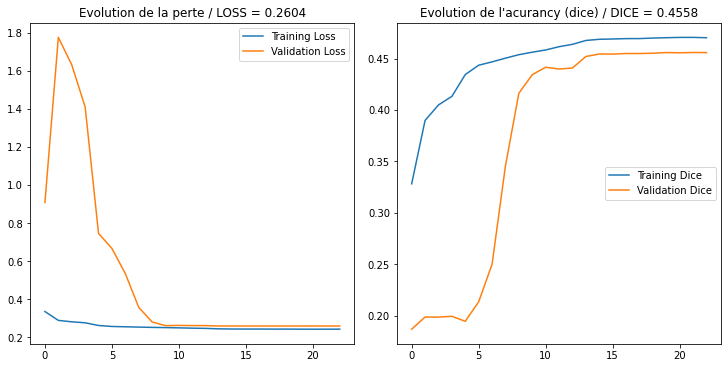

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), constrained_layout=True)
loss = history.history['loss']
val_loss = history.history['val_loss']
  
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

epochs_range = range(len(loss))

ax[0].plot(epochs_range, loss, label='Training Loss')
ax[0].plot(epochs_range, val_loss, label='Validation Loss')
ax[0].legend(loc='upper right')
ax[0].set_title("Evolution de la perte / LOSS = " + str(np.round(val_loss[-1], 4)))  

ax[1].plot(epochs_range, dice, label='Training Dice')
ax[1].plot(epochs_range, val_dice, label='Validation Dice')
ax[1].legend(loc='center right')
ax[1].set_title("Evolution de l'acurancy (dice) / DICE = " + str(np.round(val_dice[-1], 4)))  


plt.show()

## **7 - Predictions et soumission Kaggle**

### **7.1 - Predictions des images de test**

Prediction des images a soumettre

In [ ]:
#On prepare un dataframe des images a predire au format attendu lors de la soumission 
df_sub = pd.read_csv('sample_submission.csv')
df_sub['image'] = df_sub['Image_Label'].apply(lambda x: x.split('_')[0])
    
#... ainsi que la liste des images a predire
sub_imgs = df_sub['image'].unique().tolist()   

In [ ]:
#Pour eviter les depassements memoire, on decoupe notre set de soumission en lots de 500 images
#puis on effectue une prediction pour chacun des lots
sub_pred = []
taille_chunk = 300 
  
sub_batch = [sub_imgs[i * taille_chunk:(i + 1) * taille_chunk] for i in range((len(sub_imgs) + taille_chunk - 1) // taille_chunk )]  
for lot in sub_batch:
    sub_generator  = MultiGenerator(lot,
                              batch_size = 1, 
                              image_size = submission_mask_size,
                              reshape = target_size,
                              base_path = repTest,
                              augment = False,
                              shuffle = False,
                              nb_canaux = nb_canaux,
                              nb_classes = nb_classes)
    lot_pred = model.predict(sub_generator, workers=1, verbose=1)
    sub_pred.append(lot_pred)

98/98 [==============================] - 6s 65ms/step


### **7.2 - Post-traitement des predictions**

#### **7.2.1 - Presentation**

Nous avons effectuer plusieurs constats lors de la phase 1, notamment que :
- la proportion de blanc des zones nuageuses varie selon la classe
- la superficie des zones nuageuses varie egalement


Ceci nous amene a deux traitements a effectuer sur les masques predits par notre modele :
- il nous faut faire varier le seuil d'activation des pixels selon la classe. Les classes Gravel et Sugar presentent en effet a des niveaux disctincts un pattern plus clairseme, par consequent laisser le seuil a 0.5 reviendrait a eliminer un grand nombre de pixels qui pourtant font partie de la zone nuageuse.
- sur la base de la nouvelle zone couverte, il nous faut eliminer les masques dont la superficie est inferieure a une limite theorique associee a la classe courante

#### **7.2.2 - Activation des pixels**

In [ ]:
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops

def trace_boundingBox(mask, canvas, color='white', text=''):
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        coin1 = (prop.bbox[3], prop.bbox[2])
        coin2 = (prop.bbox[1], prop.bbox[0])
        cv2.rectangle(canvas, coin2, coin1, color, 10)
 

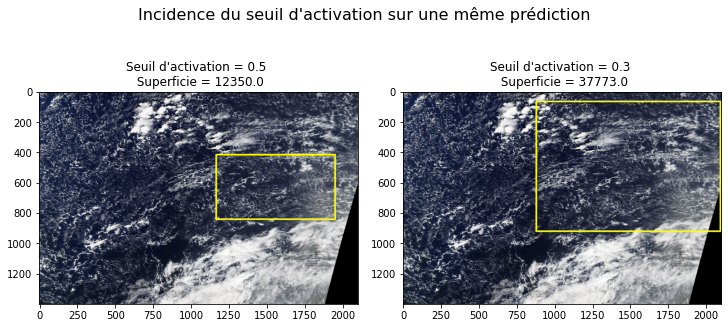

In [ ]:
#Test de seuil de masque sur la premiere image

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), constrained_layout=True)
fig.suptitle("Incidence du seuil d'activation sur une même prédiction", fontsize=16)

lot = sub_pred[0]

pred_masks1 = cv2.threshold(lot[0, :, :, 3], 0.5, 1, cv2.THRESH_BINARY)[1]
im1 = plt.imread(os.path.join(repTest, sub_imgs[0]))

trace_boundingBox(np_transposition(pred_masks1, origin_size), im1, color=(255, 255, 0), text='Sugar')
ax1.imshow(im1) 
ax1.set_title("Seuil d'activation = 0.5 \n Superficie = " + str(pred_masks1.sum()))
                
pred_masks2 = cv2.threshold(lot[0, :, :, 3], 0.3, 1, cv2.THRESH_BINARY)[1]
im2 = plt.imread(os.path.join(repTest, sub_imgs[0]))

trace_boundingBox(np_transposition(pred_masks2, origin_size), im2, color=(255, 255, 0), text='Sugar')
ax2.imshow(im2)  
ax2.set_title("Seuil d'activation = 0.3 \n Superficie = " + str(pred_masks2.sum()))

plt.show()



A gauche le seuil d'activation est a 0.5, il s'agit du seuil par defaut, qui aurait par exemple etait applique lors d'une simple conversion de la probabilite du pixel en int. A droite, le seuil a ete place a 0.3<br>
On constate une grande incidence dans la superficie de la zone couverte, il s'agit donc d'un parametre a ne pas negliger. <br>

Nous pouvons rapprocher cette notion de la proportion de blanc determinee par classe de nuage lors de la phase 1 :
- Fish : 30 %
- Flower : 30 %
- Gravel : 20 %
- Sugar : 13%

Les classes Fish et Flower presentent un taux de blanc identique, nous allons laisser pour ces classes le seuil par defaut de 0.5. Pour les classes Gravel et Sugar, le blanc est plus diffus, il nous faut donc diminuer le seuil. Nous avons choisi de placer ce seuil respectivement a 0.4 et 0.33.

In [ ]:
maskSeuils   = [.5, .5, .4, .33]


#### **7.2.3 - Superficie et calcul des percentiles**

Il peut etre interressant de visualiser la distribution des surfaces du set d'apprentissage et celles du set de prediction, apres l'application de notre seuil d'activation.. 

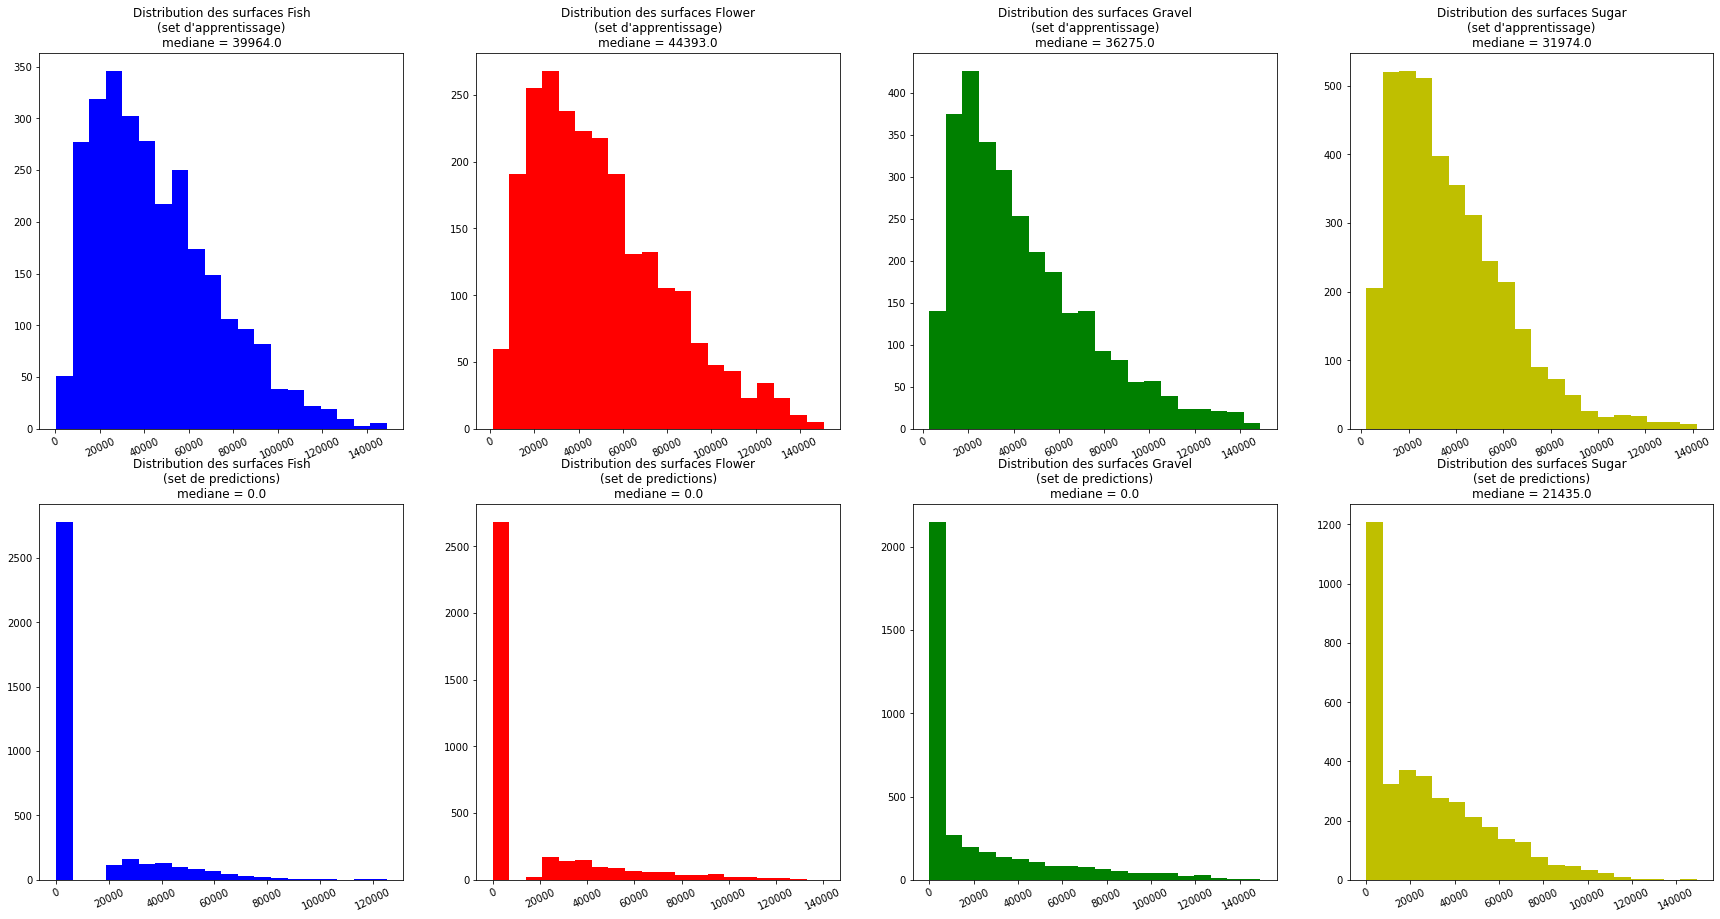

In [ ]:
def get_surfaces(classe, facteur):
    surfaces = []

    for rle in train_transformed[classe]:
        if not isinstance(rle, float):
            surfaces.append(packages.surfaceFromRle(rle) / facteur)

    return surfaces

facteur = (origin_size[0] * origin_size[1]) / (target_size[0] * target_size[1])
surfaces = []
surfaces.append(get_surfaces('Fish', facteur))
surfaces.append(get_surfaces('Flower', facteur))
surfaces.append(get_surfaces('Gravel', facteur))
surfaces.append(get_surfaces('Sugar', facteur))
couleurs=['b', 'r', 'g', 'y']


fig, ax = plt.subplots(figsize=(30, 65))

for i in range(len(formations_nuageuses)):
    plt.subplot(8,4,i+1)
    plt.hist(surfaces[i], bins=20, color=couleurs[i])
    plt.title("Distribution des surfaces " + formations_nuageuses[i] + "\n(set d'apprentissage)\nmediane = " + str(round(np.median(surfaces[i]),0)))
    plt.xticks(rotation = 25)

surfaces_predites = [None] * len(formations_nuageuses)
for classe in range(len(formations_nuageuses)):
    surfaces_predites[classe] = []
    for lot in sub_pred:             #pour chaque lot ...
        for i in range(len(lot)):    #... et chaque image

            #On recupere les masques predits pour l'ensemble des classes
            pred_masks = lot[i, ]
            seuil = maskSeuils[classe]
            pred_mask = cv2.threshold(pred_masks[ :, :, classe], seuil, 1, cv2.THRESH_BINARY)[1]
            surfaces_predites[classe].append(pred_mask.sum())

for i in range(len(formations_nuageuses)):
    plt.subplot(8,4,i+5)
    plt.hist(surfaces_predites[i], bins=20, color=couleurs[i])
    plt.title("Distribution des surfaces " + formations_nuageuses[i] + "\n(set de predictions)\nmediane = " + str(round(np.median(surfaces_predites[i]),0)))
    plt.xticks(rotation = 25)

plt.show()



Nous pouvons constater que dans les valeurs faibles de surface il y a un nombre tres important de petites surfaces. Ces dernieres vont nuire au score final du modele, il nous faut les filtrer.<br>

Pour cela nous etablissons tout d'abord, sur la base du set d'apprentissage, les percentiles propres a chaque classe. Nous allons retenir au final le 10e percentile.

In [ ]:
def get_percentiles(classe, facteur):
    surfaces = []

    for rle in train_transformed[classe]:
        if not isinstance(rle, float):
            surfaces.append(packages.surfaceFromRle(rle))

    return np.percentile(np.array(surfaces), [10, 50, 90]) / facteur

facteur = (origin_size[0] * origin_size[1]) / (target_size[0] * target_size[1])

percentiles = []
percentiles.append(get_percentiles('Fish', facteur))
percentiles.append(get_percentiles('Flower', facteur))
percentiles.append(get_percentiles('Gravel', facteur))
percentiles.append(get_percentiles('Sugar', facteur))

for indice, classe in enumerate(formations_nuageuses):
    print('percentiles ', classe, ' : ', percentiles[indice])


percentiles  Fish  :  [13799.39265306 39964.36897959 84030.74612245]
percentiles  Flower  :  [15832.67004082 44392.59428571 93079.61469388]
percentiles  Gravel  :  [13063.38742857 36275.2        86109.16310204]
percentiles  Sugar  :  [11666.49469388 31974.19102041 69349.51183673]


Une fois le 10e percentile determine pour chaque classe de nuage nous filtrons des surfaces predites les surfaces inferieures au percentile de la classe a laquelle elles sont rattachees.

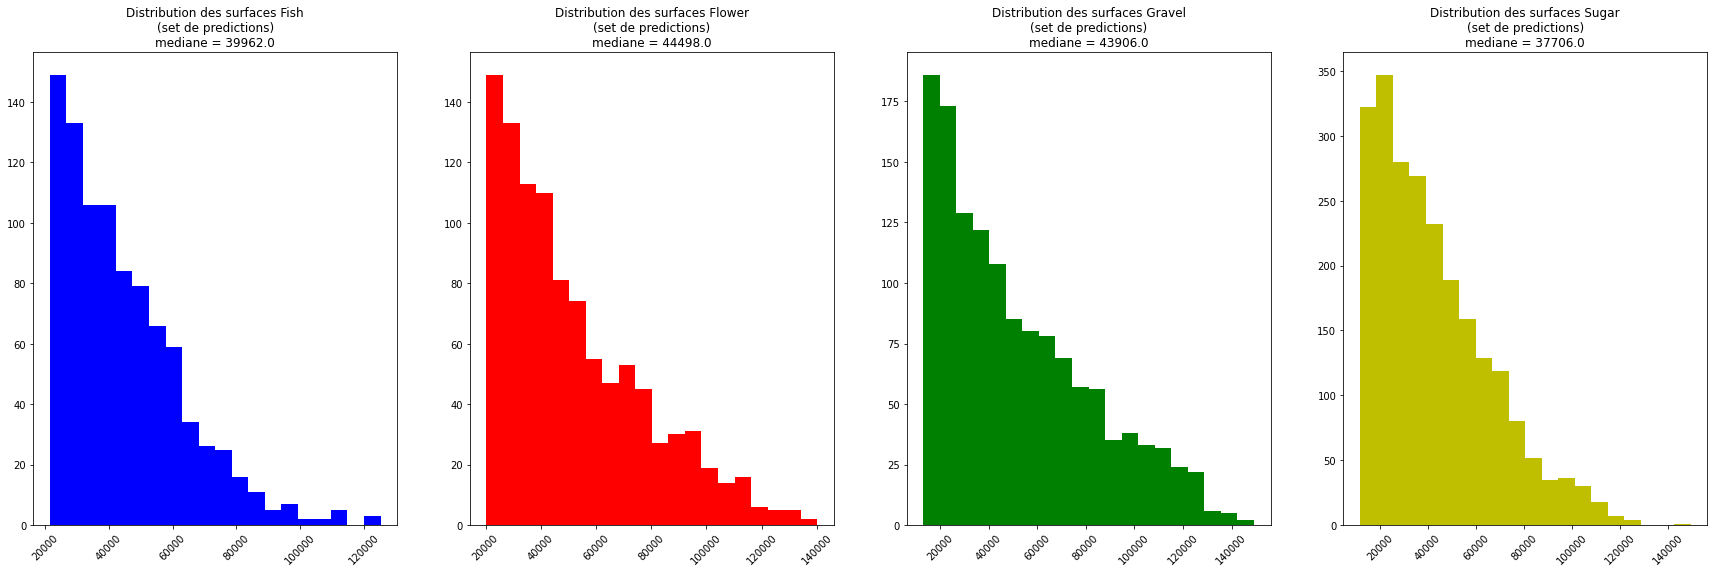

In [ ]:
fig, ax = plt.subplots(figsize=(30, 40))
for i in range(len(formations_nuageuses)):
    plt.subplot(4,4,i+1)
    surfaces_filtrees = list(filter(lambda surface: surface >= percentiles[i][0], surfaces_predites[i]))
    plt.hist(surfaces_filtrees, bins=20, color=couleurs[i])
    plt.title("Distribution des surfaces " + formations_nuageuses[i] + "\n(set de predictions)\nmediane = " + str(round(np.median(surfaces_filtrees),0)))
    plt.xticks(rotation = 45)

plt.show()

Nous obtenons une distribution qui a certes etait amputee des valeurs les plus faibles mais dont la mediane se rapproche delle de la distributions de reference du set d'apprentissage.

#### **7.2.4 - Post-traitement**

Nous synthetisons dans cette partie les differents retraitements detailles precedemment pour modifier les masques de predictions en consequence.

In [ ]:
def postTraitements(pred_mask, seuil, surface):

    #Activation des pixels sur la base d'un seuil specifique
    pred_mask = cv2.threshold(pred_mask, seuil, 1, cv2.THRESH_BINARY)[1]

    #on verifie la superficie qui en resulte ...
    # ... la taille minimale est atteinte, on retient ce masque
    if pred_mask.sum() >= surface:
        return pred_mask
    
    # ... la taille minimale n'est pas atteinte, on fait un reset du masque
    return  np.zeros(pred_mask.shape, np.float32) 

In [ ]:
#Pour chacun des lots on genere les encodage RLE associes aux predictions
#Il faut bien faire attention de specifier la taille de masque attendue par Kaggle

#On realise en meme temps un traitement complementaire sur les masques :
# 1 -> application d'un seuil d'activation des pixels (par defaut a 0.5)
#      Lors de la phase 1 nous avions determiner la proportion de blanc par classe
#      de nuages [0.3, 0.3, 0.2, 0.13]. si on ramene le cursor a 0.5 nous obtenons
#      les seuils suivants : [0.5, 0.5, 0.4, 0.33]
#
# 2 -> Elimination des surfaces trop petites
#      Nous ne retenons que les surfaces superieures au 10e percentiles de chaque
#      classe.


#La classe Sugar presente un pattern plus clairseme, aussi imposer un seuil de 0.5
#comme pour les autres classes de nuages a pour effet de retenir une zone plus petite 
#que la zone reelle, il faut donc etre plus permissif et diminuer le seuil pour cette
#classe.

sub_rles = []

for lot in sub_pred:             #pour chaque lot ...
    for i in range(len(lot)):    #... et chaque image

        #On recupere les masques predits pour l'ensemble des classes
        pred_masks = lot[i, ]

        #Pour chaque classe ...
        for classe in range(len(formations_nuageuses)):

            #On recupere le seuil associe
            seuil = maskSeuils[classe]

            #ainsi que la surface minimum voulue
            surface = percentiles[classe][0] 

            #Traitement du masque
            pred_masks[ :, :, classe] = postTraitements(pred_masks[ :, :, classe], seuil, surface)

        #Le traitement complementaire etant termine, on convertit les masques en code RLE
        pred_rles = list_maskToRle(pred_masks, reshape=submission_mask_size)
        sub_rles.append(pred_rles)


### **7.3 - Constitution du fichier de soumission**

In [ ]:
#Ensuite on met a jour le dataframe de soumission
row = 0
for prediction in sub_rles:
    for i in range(len(formations_nuageuses)):
        df_sub.EncodedPixels[row] = prediction[i]
        row += 1

In [ ]:
#La soumission Kaggle doit compter 14792 predictions pour etre valide
df_sub.shape

(14792, 3)

In [ ]:
#Mise en forme et sauvegarde du fichier de soumission Kaggle
output_filename = checkpointName
final_sub = df_sub.drop(['image'], axis = 1)
final_sub.to_csv(output_filename + '.csv', index=False)

#Compression du fichier de sortie
#Sur le site de la competition Kaggle preconise un upload au format zip pour
#gagner en temps de traitement
zip_file = zipfile.ZipFile(output_filename + '.zip', 'w')
zip_file.write(output_filename + '.csv', compress_type=zipfile.ZIP_DEFLATED)
zip_file.close()

## **8 - Predictions ponctuelles**

Predictions des images de tests (si touefois des images ont ete mises de cote)

In [ ]:
#Constitution d'un lot d'images a predire

data_collector, test_collector = packages.splitValid(train_transformed['image'], test_size=test_size)
test_imgs = test_collector.tolist()


In [ ]:
#Predictions des zones nuageuses
test_generator = MultiGenerator(test_imgs,
                              batch_size=batchSize, 
                              reshape=target_size,
                              augment=False,
                              shuffle=False,
                              nb_canaux=nb_canaux,
                              nb_classes=nb_classes)
prediction_masks = model.predict(test_generator, workers=1, verbose=1)

7/7 [==============================] - 12s 2s/step


In [ ]:
#Post-traitement des predictions

#prediction_masks_processed = prediction_masks
prediction_masks_processed = np.copy(prediction_masks)
           
for i in range(len(prediction_masks_processed)):    # pour chaque image

    #Pour chaque classe ...
    for classe in range(len(formations_nuageuses)):

        #On recupere le seuil associe
        seuil = maskSeuils[classe]

        #ainsi que la surface minimum voulue
        surface = percentiles[classe][0] 

        #Traitement du masque
        prediction_masks_processed[i, :, :, classe] = postTraitements(prediction_masks_processed[i, :, :, classe], seuil, surface)

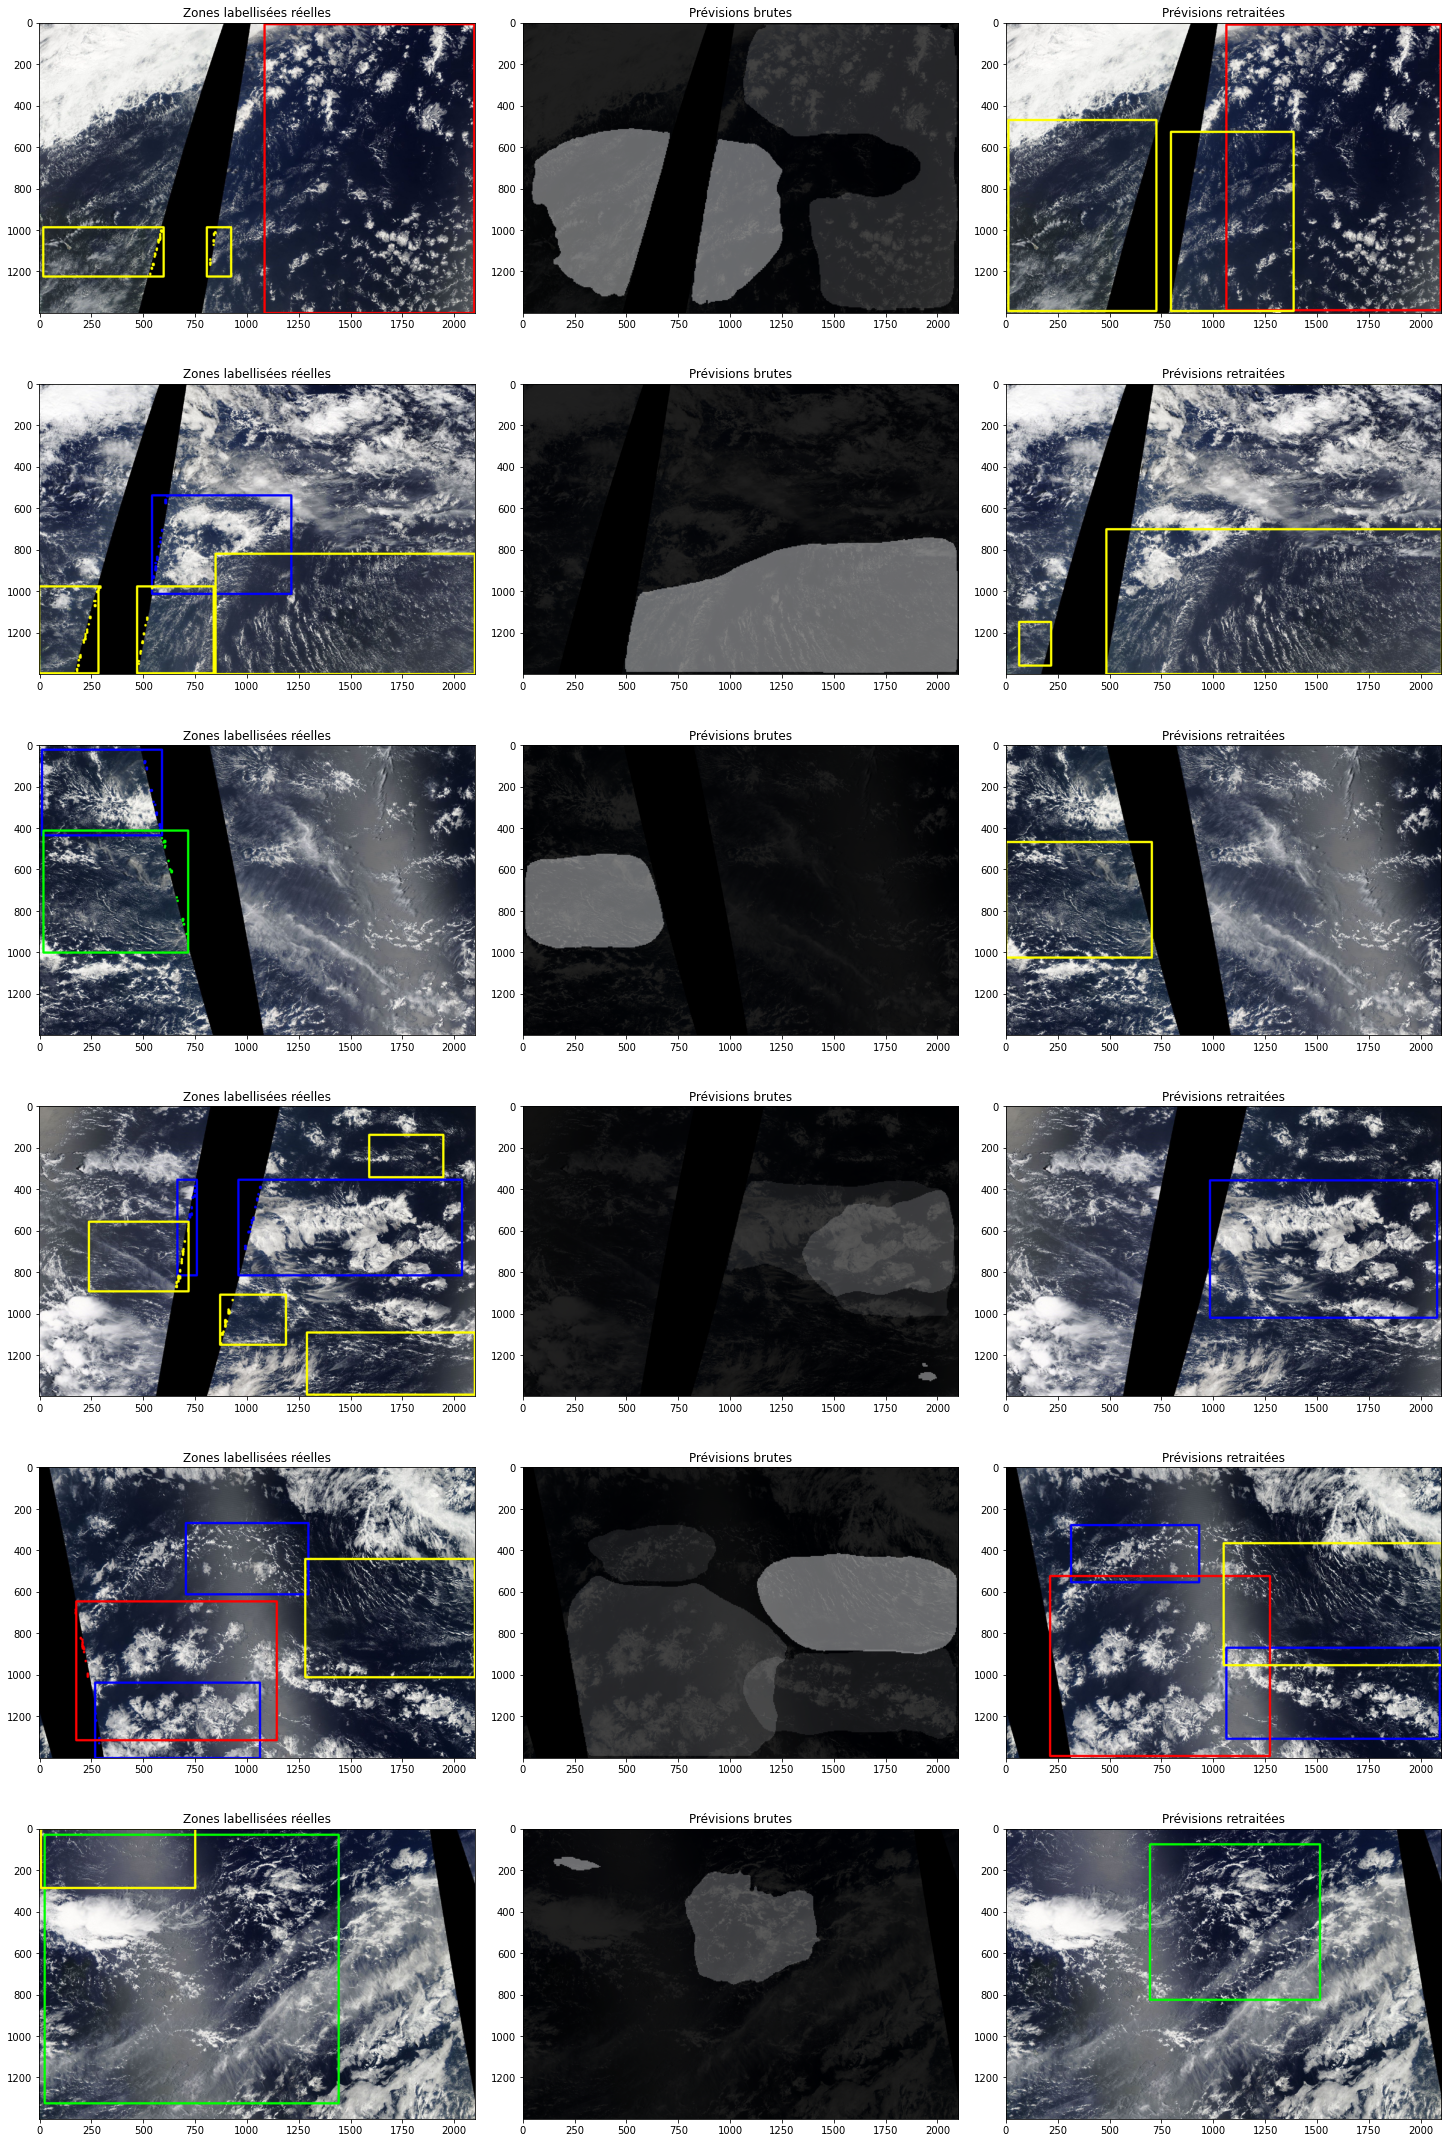

In [ ]:
#Confusion des predictions et des donnees reelles

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20, 30), constrained_layout=True)

couleurs=[(0,0,255), (255,0,0), (0,255,0), (255,255,0)]
nb_images = 6
j= 0
for i in range(nb_images):

    pred_masks = prediction_masks[i, ].round().astype(int)
    pred_rles = list_maskToRle(pred_masks, reshape=origin_size)

    pred_masks_processed = prediction_masks_processed[i, ].round().astype(int)
    pred_rles_processed = list_maskToRle(pred_masks_processed, reshape=origin_size)


    im = plt.imread(os.path.join(repTrain, test_imgs[i]))
    for indice, rle in enumerate(index_classes[test_imgs[i]]) :
        if not isinstance(rle, float):
            mask = packages.rleToMask(rle, origin_size)
            trace_boundingBox(mask, im, color=couleurs[indice], text=formations_nuageuses[indice]) 
    ax[i,0].imshow(im) 
    ax[i,0].set_title("Zones labellisées réelles")   


    im2 = plt.imread(os.path.join(repTrain, test_imgs[i]))
    ax[i,1].imshow(im2)   
    ax[i,1].set_title("Prévisions brutes")        
    for k in range(4):
        mask = packages.rleToMask(pred_rles[k], origin_size)
        ax[i,1].imshow(mask, alpha=0.4, cmap="gray")   


    im3 = plt.imread(os.path.join(repTrain, test_imgs[i]))
   
    for k in range(4):
        mask = packages.rleToMask(pred_rles_processed[k], origin_size)
        trace_boundingBox(mask, im3, color=couleurs[k], text=formations_nuageuses[k])

    ax[i,2].imshow(im3) 
    ax[i,2].set_title("Prévisions retraitées") 

plt.show()